# Multi-modal Search on the Amazon Reviews Dataset


## Introduction

The [_Amazon Product Dataset_](http://jmcauley.ucsd.edu/data/amazon/links.html) contains product metadata, reviews, and image feature vectors for 9.4 million Amazon products. The dataset was collected by researchers at UCSB. For more information, see the paper _Justifying recommendations using distantly-labeled reviews and fined-grained aspects_ by Jianmo Ni, Jiacheng Li, and Julian McAuley. 

In this tutorial, we'll use the metadata and image feature vectors from the "Home and Kitchen" category to demonstrate how Elastiknn can be used for multi-modal search. Specifically, we will search for products using simple keywords, search for similar products based on images, and search for similar products based on combinations of keywords and product images.

The tutorial assumes you are comfortable with Python and the Elasticsearch JSON API and have successfully [installed Elastiknn](https://elastiknn.com/installation/).

## Download the Data

Download two files:

1. meta_Home_and_Kitchen.json.gz - contains the product metadata.
2. image_features_Home_and_Kitchen.b - contains pre-computed image vectors.

In [1]:
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Home_and_Kitchen.json.gz
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/image_features/categoryFiles/image_features_Home_and_Kitchen.b    

File ‘image_features_Home_and_Kitchen.b’ already there; not retrieving.



## Explore the Data

Let's have a look at some of the data. 

I've included a module `amazonutils` which includes some functions for iterating over the data. Let's import that, as well as some other simple utilities.

In [6]:
from amazonutils import *
from itertools import islice
from pprint import pprint
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np

fname_products = "meta_Home_and_Kitchen.json.gz"
fname_vectors = "image_features_Home_and_Kitchen.b"

First we'll iterate over the metadata for a few products. Notice each product's metadata is a dictionary containing a title, description, image url, etc. We'll display the images using the URL.

{'asin': '0076144011',
 'categories': [['Home & Kitchen']],
 'imUrl': 'http://g-ecx.images-amazon.com/images/G/01/x-site/icons/no-img-sm._CB192198896_.gif',
 'salesRank': {'Books': 6285595},
 'title': 'Ninjas, Piranhas, and Galileo'}


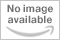

{'asin': '0130350591',
 'categories': [['Home & Kitchen',
                 'Kitchen & Dining',
                 'Dining & Entertaining',
                 'Serveware',
                 'Butter Dishes']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/21zcx6RCDoL.jpg',
 'salesRank': {'Kitchen & Dining': 459680},
 'title': 'Le Creuset Kiwi (Green) Butter Dish Stoneware'}


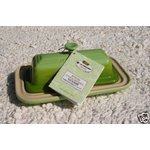

{'asin': '0307394530',
 'brand': 'Random House',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51A4FWujzgL._SY300_.jpg',
 'price': 14.99,
 'salesRank': {'Arts, Crafts & Sewing': 3597},
 'title': "Martha Stewart's Wedding Cakes"}


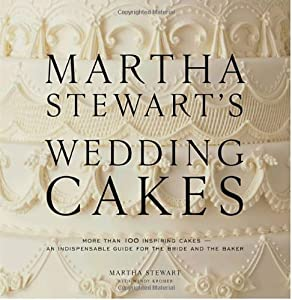

{'asin': '0439903491',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/61tVxckoYUL._SY300_.jpg',
 'price': 29.99,
 'salesRank': {'Software': 7065}}


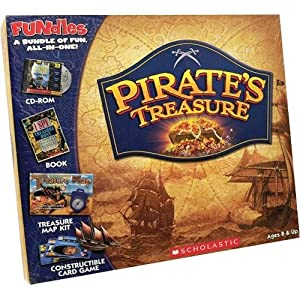

{'asin': '0578060604',
 'categories': [['Home & Kitchen',
                 'Furniture',
                 'Kitchen & Dining Room Furniture',
                 'Chairs']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/41aCELWJgWL._SY300_.jpg',
 'title': 'Build A Maloof Inspired Low Back Dining Chair with Charles Brock'}


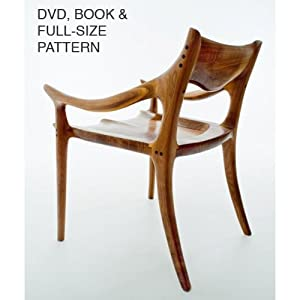

{'asin': '0587234792',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51DPFpHmhuL._SX300_.jpg',
 'salesRank': {'Home &amp; Kitchen': 4867920},
 'title': '&quot;Coos Bay Lighthouse&quot; Print (Canvas 20x30)'}


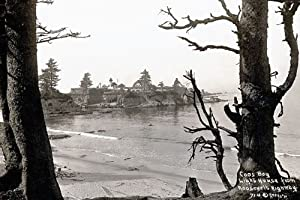

{'asin': '0587010584',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/41W9TsKkY5L._SY300_.jpg',
 'price': 16.95,
 'salesRank': {'Home &amp; Kitchen': 3727362},
 'title': "Marionette Theater Presents RUR (Rossum's Universal Robots)"}


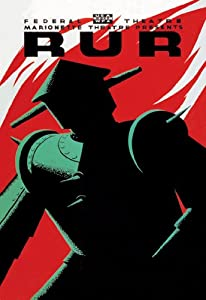

{'asin': '0587168978',
 'brand': 'Buyenlarge',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/415hRb4C0TL._SX300_.jpg',
 'price': 26.72,
 'salesRank': {'Home &amp; Kitchen': 1707155},
 'title': '&quot;Daybreak&quot; Print (Unframed Paper Print 20x30)'}


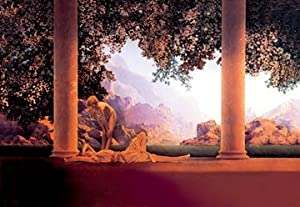

{'asin': '0587218959',
 'brand': 'Buyenlarge',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/310M9-V-RrL.jpg',
 'price': 11.88,
 'salesRank': {'Home &amp; Kitchen': 3882566},
 'title': 'Look Pretty Have Fun - 12x18 Art Poster by Fashion Frocks'}


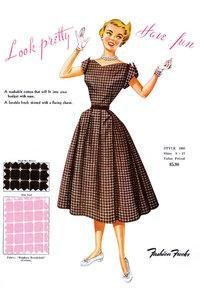

{'asin': '0587217189',
 'brand': 'Buyenlarge',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51j27YQPyTL._SY300_.jpg',
 'price': 16.95,
 'salesRank': {'Home &amp; Kitchen': 4172092},
 'title': 'The Great McEwen, famous Scottish hypnotist 20x30 Poster Paper'}


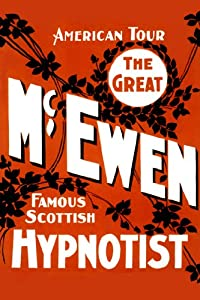

In [3]:
for p in islice(iter_products(fname_products), 10):
    pprint({k:v for (k,v) in p.items() if k not in {'related', 'description'}})
    display(Image(p['imUrl'], width=128, height=128))

Next we'll use the `iter_vectors` function to iterate over product IDs and image vectors. Each vector is just a list of 4096 floats, generated using a deep convolutional neural network.

There's not much value in inspecting the individual vectors, so we'll just show the first few values for each one. 

Then we'll sample a subset of vectors and plot the distribution of values. Note that there are many zeros.

b'B0007Y05RW' [0.0, 3.7047998905181885, 2.638200044631958, 0.0, 0.0] ...
b'B000BMIAO0' [0.0, 1.323199987411499, 0.0, 0.0, 2.02020001411438] ...
b'B000FMJ3YM' [0.0, 0.0, 2.499300003051758, 0.0, 0.0] ...
b'B000FU4H7C' [0.0, 0.0, 0.0, 0.0, 6.170599937438965] ...
b'B000FFIVGK' [0.0, 0.0, 0.0, 0.0, 0.0] ...
b'B000FQG5U8' [1.1913000345230103, 1.9945000410079956, 0.0, 0.0, 0.0] ...
b'B000B6J59U' [0.0, 2.241499900817871, 1.347599983215332, 0.0, 0.5848000049591064] ...
b'B000FO6FIW' [0.0, 0.0, 0.0, 0.0, 1.7311999797821045] ...
b'B000BJEZF6' [0.0, 2.8742001056671143, 0.0, 0.0, 0.0] ...
b'B000E6OMUO' [0.0, 0.7900999784469604, 0.0, 0.0, 0.0] ...


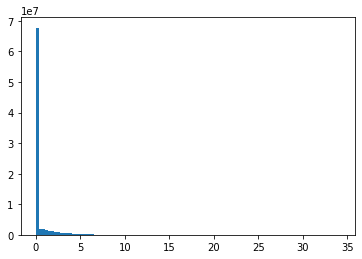

In [13]:
for (asin, vec) in islice(iter_vectors(fname_vectors), 10):
    print(asin, vec[:5], '...')
    
sample = np.array([v for (_, v) in islice(iter_vectors(fname_vectors), 20000)])

plt.hist(np.ravel(sample), bins=100)
plt.show()

## Create the Elasticsearch Index

## Index the Products

## Run Standard Keyword Queries

## Run Image Similarity Queries

## Combine Keyword and Image Similarity Queries